In [1]:
from __future__ import print_function
from __future__ import division

import sys

# sys.path.insert(0, '/home/dbutts/Code/')
sys.path.insert(0, 'C:\\Users\\Jake\\Documents\\')
sys.path.insert(0, 'C:\\Users\\Jake\\Documents\\NDN3')

import NDN3.NDNutils as NDNutils
# which_gpu = NDNutils.assign_gpu()
#NDNutils.setup_no_gpu()
# NDNutils.setup_no_gpu()


import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

import h5py
import numpy as np
import tensorflow as tf
import scipy.io as sio           # importing matlab data
import matplotlib.pyplot as plt  # plotting
%matplotlib notebook
from copy import deepcopy

import time
import random
import NDN3.NDN as NDN
#import TNDN as TNDN
import NDN3.Utils.DanUtils as DU
import NDN3.Utils.NDNplot as NDNplot
output_dir = 'C:\\Users\\Jake\\Dropbox\\Projects\\NDN\\output_dir'
# output_dir = '/Users/dbutts/Code/PyPlay/tensorboard'
print(sys.version)
# import sys
# print(sys.path)


print(output_dir)

3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
C:\Users\Jake\Dropbox\Projects\NDN\output_dir


In [2]:
# Load Data
dirname = "C:\\Users\\Jake\\Dropbox\\Projects\\FreeViewing\\Data\\"
includeSaccades=True

matdat=sio.loadmat(dirname + 'L20191231_Gabor.mat')

frameTimes1 = matdat['frameTimes'].copy()
stim1 = matdat['stim'].copy()
Robs1 = matdat['Robs'].copy()
valdat1 = matdat['valdata'].copy()
labels1 = matdat['labels'].copy()
if includeSaccades:
    valid1 = np.intersect1d(np.where(valdat1[:,0] == 1)[0], np.where(labels1[:,0] == 1)[0])
else:
    valid1 = np.intersect1d(np.where(valdat1[:,0] == 1)[0], np.where(np.logical_or(labels1[:,0]==2,labels1[:,0]==1))[0])
    
slist1 = matdat['slist'].astype(int)
dt = matdat['dt'][0][0]
NY = matdat['NX'][0][0].astype(int)
NP = stim1.shape[1]
ets1 = matdat['eyeAtFrame']
NX = (NP//NY).astype(int)
NT1,NCfull = Robs1.shape

matdat = sio.loadmat(dirname + 'L20191231_Grating.mat')
frameTimes2 = matdat['frameTimes'].copy()
stim2 = matdat['stim'].copy()
Robs2 = matdat['Robs'].copy()
valdat2 = matdat['valdata'].copy()
labels2 = matdat['labels'].copy()
# valid2 = np.intersect1d(np.where(valdat2[:,0] == 1)[0], np.where(labels2[:,0] == 1)[0])
if includeSaccades:
    valid2 = np.intersect1d(np.where(valdat2[:,0] == 1)[0], np.where(labels2[:,0] == 1)[0])
else:
    valid2 = np.intersect1d(np.where(valdat2[:,0] == 1)[0], np.where(np.logical_or(labels2[:,0]==2,labels2[:,0]==1))[0])
    
slist2 = matdat['slist'].astype(int)
ets2 = matdat['eyeAtFrame']
NT2 = Robs2.shape[0]
print(NT1, NT2, NCfull,'|', NX, NY)

matdat = sio.loadmat(dirname + 'L20191231_FixRsvpStim.mat')
frameTimes3 = matdat['frameTimes'].copy()
# matdat = sio.loadmat(dirname + 'L20191231_BackImage.mat')
stim3 = matdat['stim'].copy()
Robs3 = matdat['Robs'].copy()
valdat3 = matdat['valdata'].copy()
labels3 = matdat['labels'].copy()
# valid3 = np.intersect1d(np.where(valdat3[:,0] == 1)[0], np.where(labels3[:,0] == 1)[0])
if includeSaccades:
    valid3 = np.intersect1d(np.where(valdat3[:,0] == 1)[0], np.where(labels3[:,0] == 1)[0])
else:
    valid3 = np.intersect1d(np.where(valdat3[:,0] == 1)[0], np.where(np.logical_or(labels3[:,0]==2,labels3[:,0]==1))[0])
    
slist3 = matdat['slist'].astype(int)
ets3 = matdat['eyeAtFrame']
NT3 = Robs3.shape[0]
print(NT1, NT2, NT3, '|', NCfull, '|', NX, NY)

96989 77320 61 | 40 40
96989 77320 5275 | 61 | 40 40


In [3]:
# Filter data assuming eye tracking is good within certain radius: still using 3.1 deg (although easy to update)
# Determine valid indices based on eye position
valid_eye_rad = 5.1  # degrees
pixPerDeg = 37.50476617061
# Radial eye position (in degrees)
er1s = np.divide(np.sqrt(np.add(np.square(ets1[:,0]-640), np.square(ets1[:,1]-360))), pixPerDeg)
er2s = np.divide(np.sqrt(np.add(np.square(ets2[:,0]-640), np.square(ets2[:,1]-360))), pixPerDeg)
er3s = np.divide(np.sqrt(np.add(np.square(ets3[:,0]-640), np.square(ets3[:,1]-360))), pixPerDeg)

# Selection of valid indices where eye tracker estimated to be valid
eyeval1 = np.intersect1d(valid1, np.where(er1s < valid_eye_rad)[0])
eyeval2 = np.intersect1d(valid2, np.where(er2s < valid_eye_rad)[0])
eyeval3 = np.intersect1d(valid3, np.where(er3s < valid_eye_rad)[0])

# Make train and test inds for each trial
Uinds1, Xinds1 = NDNutils.generate_xv_folds(len(eyeval1), num_blocks=2)
Uinds2, Xinds2 = NDNutils.generate_xv_folds(len(eyeval2), num_blocks=2)
Uinds3, Xinds3 = NDNutils.generate_xv_folds(len(eyeval3), num_blocks=2)

In [4]:
### Concatenate data: 3 conditions
spaceL = 60
Sspacer = np.zeros([spaceL, NP], dtype='float32')
Rspacer = np.zeros([spaceL, NCfull], dtype='float32')
Tspacer = np.zeros([spaceL, 1], dtype='float32')
frameTimesAll = np.concatenate((frameTimes1, Tspacer, frameTimes2, Tspacer, frameTimes3), axis=0)
RobsAll = np.concatenate( (Robs1, Rspacer, Robs2, Rspacer, Robs3), axis=0)
# Assemble valid data and translate Ui's and Xi's 
valdata = np.concatenate( (eyeval1, eyeval2+NT1+spaceL, eyeval3+NT1+NT2+2*spaceL), axis=0 )
Ui1, Xi1 = Uinds1.copy(), Xinds1.copy()
Ui2, Xi2 = Uinds2.copy()+len(eyeval1), Xinds2.copy()+len(eyeval1)
Ui3, Xi3 = Uinds3.copy()+len(eyeval1)+len(eyeval2), Xinds3.copy()+len(eyeval1)+len(eyeval2)
Ui = np.concatenate((Ui1, Ui2, Ui3), axis=0)
Xi = np.concatenate((Xi1, Xi2, Xi3), axis=0)

stim = np.concatenate( (stim1.copy(), Sspacer.copy(), stim2.copy(), Sspacer.copy(), stim3.copy()), axis=0)
stim_norm = np.std(stim[valdata,:], axis=0)
stim = np.divide( stim, stim_norm)

NTfull = stim.shape[0]
NT = valdata.shape[0]

# Process saccades -- just store sacc offsets as delta functions
sac_on, sac_off = np.zeros([NTfull,1], dtype='float32'), np.zeros([NTfull,1], dtype='float32')
for nn in range(slist1.shape[0]):
    sac_on[slist1[nn,0]-1] = 1.0
    sac_off[slist1[nn,1]-1] = 1.0
for nn in range(slist2.shape[0]):
    sac_on[slist2[nn,0]-1+NT1+spaceL] = 1.0
    sac_off[slist2[nn,1]-1+NT1+spaceL] = 1.0
for nn in range(slist3.shape[0]):
    sac_on[slist3[nn,0]-1+NT1+NT2+2*spaceL] = 1.0
    sac_off[slist3[nn,1]-1+NT1+NT2+2*spaceL] = 1.0
    
ex = np.concatenate( (ets1[:,0].copy(), Sspacer[:,0], ets2[:,0].copy(), Sspacer[:,0], ets3[:,0].copy()), axis=0)-640
ey = np.concatenate( (ets1[:,1].copy(), Sspacer[:,0], ets2[:,1].copy(), Sspacer[:,0], ets3[:,1].copy()), axis=0)-360
print("Data size: %d (%d valid)"%(NTfull, NT) )
print("Train: %6d (%5d +%5d +%5d)"%(len(Ui), len(Ui1), len(Ui2), len(Ui3)))
print("Test:  %6d (%5d +%5d +%5d)"%(len(Xi), len(Xi1), len(Xi2), len(Xi3)))

Data size: 179704 (105968 valid)
Train:  84774 (42637 +38429 + 3708)
Test:   21194 (10660 + 9608 +  926)


In [5]:
# Data adjustment
Nspks = np.sum(RobsAll[valdata,:],axis=0)
valcell = np.where(Nspks > 500)[0]  # arbitrary cutoff at this point...
NC = len(valcell)
Robs = RobsAll[:,valcell]
print( "%d out of %d cells selected"%(NC, RobsAll.shape[1]) )

58 out of 61 cells selected


In [21]:
adam_params = NDN.NDN.optimizer_defaults(opt_params={'use_gpu': True}, learning_alg='adam')

early_stopping = 100

adam_params['batch_size'] = NT // 1000
adam_params['display'] = 30
adam_params['epochs_training'] = early_stopping * 10
adam_params['run_diagnostics'] = False

adam_params['epsilon'] = 1e-8
adam_params['early_stop'] = early_stopping
adam_params['early_stop_mode'] = 11
#adam_params['data_pipe_type'] = 'iterator'
adam_params['data_pipe_type'] = 'data_as_var'
adam_params['learning_rate'] = 1e-3
#adam_params['epochs_summary'] = 5
for d in adam_params:
    print("%20s:\t %s" %(d, adam_params[d]))

lbfgs_params = NDN.NDN.optimizer_defaults(opt_params={'use_gpu': True, 'display': True}, learning_alg='lbfgs')
lbfgs_params['maxiter'] = 1000
# print('\nLBFGS:')
# for d in lbfgs_params:
#     print("%20s:\t %s" %(d, lbfgs_params[d]))

             use_gpu:	 True
             display:	 30
      data_pipe_type:	 data_as_var
   poisson_unit_norm:	 None
         epochs_ckpt:	 None
       learning_rate:	 0.001
          batch_size:	 105
     epochs_training:	 1000
     early_stop_mode:	 11
      epochs_summary:	 None
          early_stop:	 100
               beta1:	 0.9
               beta2:	 0.999
             epsilon:	 1e-08
     run_diagnostics:	 False


## Format stimulus and plot STAs

In [7]:
num_lags = 10
tmp = NDNutils.create_time_embedding( stim, [num_lags, NX, NX], tent_spacing=1 )
Xstim = deepcopy(tmp[valdata,:])

In [8]:
# Shift responses to take out first lag (just why bother with it)
Robs = NDNutils.shift_mat_zpad(RobsAll[:,valcell], -1, dim=0)
# STAs
stas = np.reshape(np.matmul(np.transpose(Xstim),Robs[valdata,:]), [NP,num_lags, NC])/len(valdata)
np.mean(np.max(abs(stas), axis=0))

0.009325508132791288

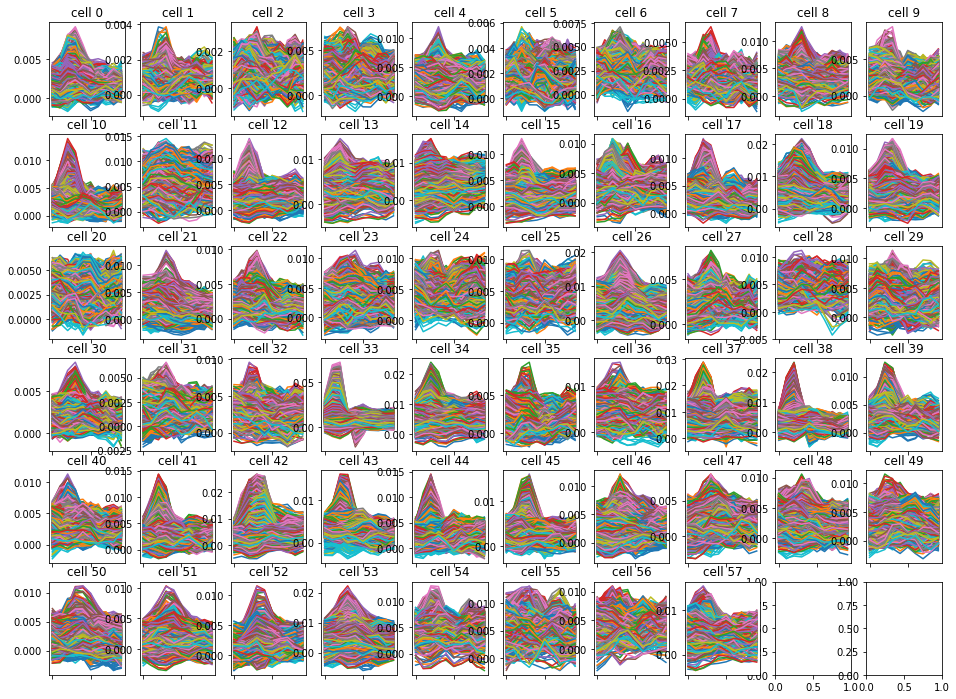

In [9]:
DU.subplot_setup(6,10)
for cc in range(NC):
    ax = plt.subplot(6,10,cc+1)
    plt.plot(np.transpose(stas[:,:,cc]))
    #ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.title('cell '+str(cc))
plt.show()

## Load prior model fits

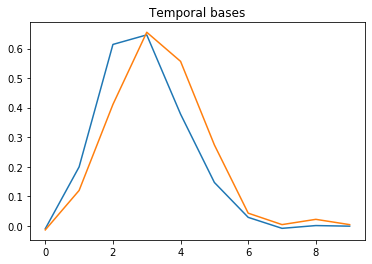

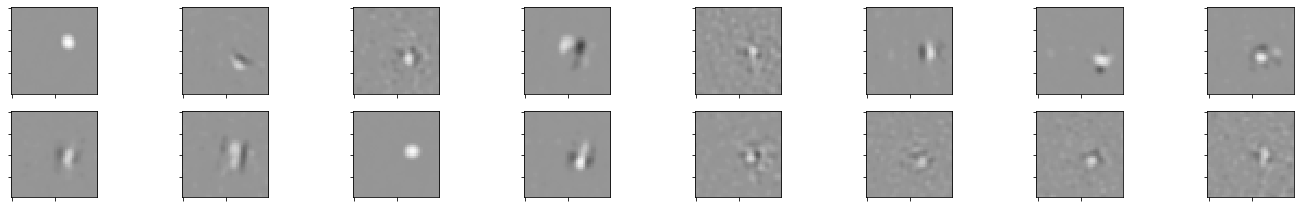

In [10]:
fname = dirname + "snim22t_1231"
snim22t = NDN.NDN.load_model(fname)

DU.plot_filters(snim22t)

## Initialize with above fit and try saccade kernels

In [11]:
# Treg = 0.01
# # Final values, after initially starting weaker
# Xreg = 0.1
# L1reg = 0.1
# LOCreg = 0.2
# shift backwards in time too (doesnt have to be causal!)
num_saclags = 40
back_shifts = 10

Xsac1 = NDNutils.create_time_embedding(NDNutils.shift_mat_zpad(sac_on,-back_shifts,dim=0), [num_saclags, 1, 1], tent_spacing=1)
Xsac2 = NDNutils.create_time_embedding(NDNutils.shift_mat_zpad(sac_off,-back_shifts,dim=0), [num_saclags, 1, 1], tent_spacing=1)
TSreg = 0.001

# intialize with previous stim-only model
prev_mod = snim22t.copy_model()

# Read off end regularization of previous model
Treg = prev_mod.networks[0].layers[0].reg.vals['d2t']
Xreg = prev_mod.networks[0].layers[1].reg.vals['d2x']
LOCreg = prev_mod.networks[0].layers[1].reg.vals['local']
L1reg = prev_mod.networks[0].layers[1].reg.vals['l1']


num_tkerns = 2
num_subs=16

## Additive saccade kernels

In [13]:
num_tkerns = 2
num_subs = 16
tnim1_par = NDNutils.ffnetwork_params( 
    input_dims=[1,NY,NX, num_lags], layer_sizes=[num_tkerns, num_subs, NC], 
    layer_types=['conv', 'normal', 'normal'], conv_filter_widths=[1], ei_layers=[None, 2],
    normalization=[1,1,0], act_funcs=['lin', 'relu', 'lin'], # note lin as last stage
    reg_list={'d2t':[Treg], 'd2x':[None, Xreg], 'l1':[None, L1reg], 'local':[None,LOCreg]})
sac1_par = NDNutils.ffnetwork_params( 
    input_dims=[1,1,1, num_saclags], xstim_n=[1],
    layer_sizes=[1, NC], layer_types=['normal', 'normal'], normalization=[1,0], 
    act_funcs=['relu', 'lin'], reg_list={'d2t':[TSreg]})  # make rectified, but don't have to
sac2_par = NDNutils.ffnetwork_params( 
    input_dims=[1,1,1, num_saclags], xstim_n=[2],
    layer_sizes=[1, NC], layer_types=['normal', 'normal'], normalization=[1, 0], act_funcs=['relu', 'lin'],
    reg_list={'d2t':[TSreg]})
comb_par = NDNutils.ffnetwork_params( 
    xstim_n=None, ffnet_n=[0,1,2], layer_sizes=[NC], layer_types=['add'], act_funcs=['softplus'])

sacnim0 = NDN.NDN( [tnim1_par, sac1_par, sac2_par, comb_par], ffnet_out=3, noise_dist='poisson' )
sacnim0.networks[0].layers[0].weights = deepcopy(prev_mod.networks[0].layers[0].weights)
sacnim0.networks[0].layers[1].weights = deepcopy(prev_mod.networks[0].layers[1].weights)
sacnim0.networks[0].layers[1].biases = deepcopy(prev_mod.networks[0].layers[1].biases)
sacnim0.networks[0].layers[2].weights = deepcopy(prev_mod.networks[0].layers[2].weights)

# initially just fit saccade kernels
v2f0 = sacnim0.fit_variables(layers_to_skip=[[0,1,2]], fit_biases=True)
v2f0[1][1]['biases']=False
v2f0[2][1]['biases']=False
v2f0[3][0]['weights']=False

# Then can fit everything but temporal kernels for stim
v2f = sacnim0.fit_variables(layers_to_skip=[[0]], fit_biases=True)
v2f[0][2]['biases']=False
v2f[1][1]['biases']=False
v2f[2][1]['biases']=False
v2f[3][0]['weights']=False

_ = sacnim0.train(
    input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], output_data=Robs[valdata,:], 
    train_indxs=Ui, test_indxs=Xi, fit_variables=v2f0, 
    learning_alg='adam', opt_params=adam_params)
#sacnim0.set_regularization('l1', 0.02, ffnet_target = 0, layer_target=1)
#_ = sacnim0.train(
#    input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], output_data=Robs[valdata,:], 
#    train_indxs=Ui, test_indxs=Xi, fit_variables=v2f, 
#    learning_alg='adam', opt_params=adam_params, output_dir=output_dir )

LL1u = sacnim0.eval_models(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Ui, nulladjusted=False)
LL1x = sacnim0.eval_models(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=False)
LL1n = sacnim0.eval_models(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=True)

print(np.mean(LL1u), np.mean(LL1x), np.mean(LL1n))

Input dimensions: [1, 40, 40, 10]
0: conv (lin):  	[E2/I0] N  	filter width = 1
1: normal (relu):  	[E14/I2] N
2: normal (lin):  	[E58/I0] +
Input dimensions: [1, 1, 1, 40]
0: normal (relu):  	[E1/I0] N
1: normal (lin):  	[E58/I0] 
Input dimensions: [1, 1, 1, 40]
0: normal (relu):  	[E1/I0] N
1: normal (lin):  	[E58/I0] 
0: add (softplus):  	[E58/I0] 
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 0000:  avg train cost =     7.2623,  avg test cost =     7.2363,  reg penalty =     0.1025
Epoch 0029:  avg train cost =     3.4547,  avg test cost =     3.3995,  reg penalty =     0.1023
Epoch 0059:  avg train cost =     3.4498,  avg test cost =     3.3935,  reg penalty =     0.1023
Epoch 0089:  avg train cost =     3.4488,  avg test cost =     3.3927,  reg penalty =     0.1023
Epoch 0119:  avg train cost =     3.4478,  avg test cost =     3.3914,  reg penalty =     0.1023
Epoch 0149:  avg train cost =     3.4468,

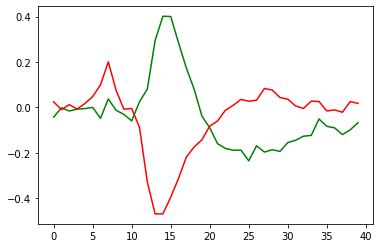

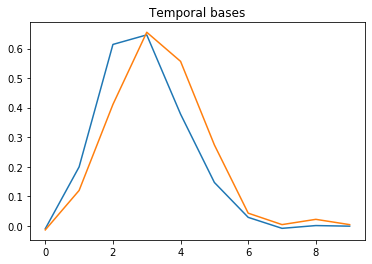

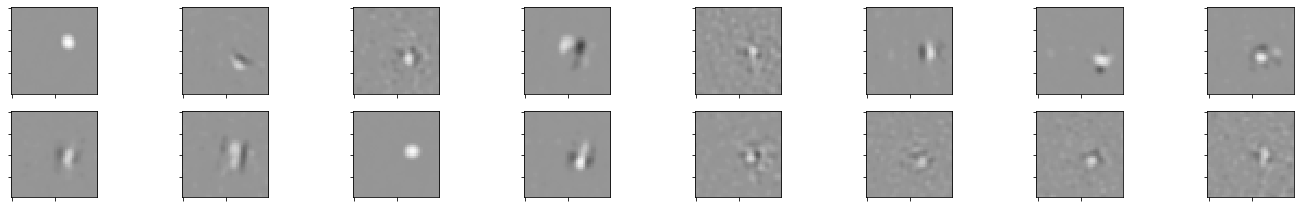

In [20]:
plt.plot(sacnim0.networks[1].layers[0].weights,'g')
plt.plot(sacnim0.networks[2].layers[0].weights,'r')
plt.show()
DU.plot_filters(sacnim0)

In [16]:
sacnim0.save_model(dirname + "sacnim0_1231")

sacnim0.matlab_export(dirname + "sacnim0export_1231")

predrate = sacnim0.generate_prediction(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]])

sio.savemat(dirname + "sacnim0_output.mat", dict([ ('LLs0', LL1x), ('predrate', predrate), ('valdata', valdata), ('Robs', Robs), ('sac_on', sac_on), ('sac_off', sac_off)]))

Model pickled to C:\Users\Jake\Dropbox\Projects\FreeViewing\Data\sacnim0_1231


In [26]:
sacnim1 = sacnim0.copy_model()
#sacnim0.set_regularization('l1', 0.02, ffnet_target = 0, layer_target=1)
_ = sacnim1.train(
    input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], output_data=Robs[valdata,:], 
    train_indxs=Ui, test_indxs=Xi, fit_variables=v2f, 
    learning_alg='adam', opt_params=adam_params)
LL1u = sacnim1.eval_models(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Ui, nulladjusted=False)
LL1x = sacnim1.eval_models(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=False)
LL1n = sacnim1.eval_models(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=True)

print(np.mean(LL1u), np.mean(LL1x), np.mean(LL1n))

Epoch 0000:  avg train cost =     3.3858,  avg test cost =     3.3566,  reg penalty =     0.1159
Epoch 0029:  avg train cost =     3.3312,  avg test cost =     3.3425,  reg penalty =     0.1083
Epoch 0059:  avg train cost =     3.3239,  avg test cost =     3.3412,  reg penalty =     0.1061
Epoch 0089:  avg train cost =     3.3211,  avg test cost =     3.3442,  reg penalty =     0.1060

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 114,  end cost: 200.385382
     ---> best epoch: 39,  best cost: 199.403633

3.325412 3.3495505 0.23211095


In [12]:
sacnim1.save_model(dirname + "sacnim1_1231")

sacnim1.matlab_export(dirname + "sacnim1export_1231")

predrate = sacnim1.generate_prediction(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]])

sio.savemat(dirname + "sacnim1_output.mat", dict([ ('LLs0', LL1x), ('predrate', predrate), ('valdata', valdata), ('Robs', Robs), ('sac_on', sac_on), ('sac_off', sac_off)]))

NameError: name 'sacnim1' is not defined

In [12]:
fname = dirname + "sacnim1_1231"
sacnim1 = NDN.NDN.load_model(fname)

In [17]:
sacnim1 = sacnim0.copy_model()
# snim22t.save_model(dirname + "snim22t_1231")

# snim22t.matlab_export(dirname + "snim22texport_1231")


# predrate = snim22t.generate_prediction(input_data=Xstim)

# sio.savemat(dirname + "snim22t_output.mat", dict([ ('LLs0', LLsX), ('predrate', predrate), ('valdata', valdata), ('Robs', Robs), ('sac_on', sac_on), ('sac_off', sac_off)]))

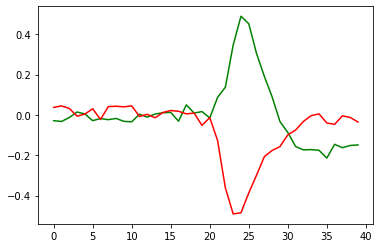

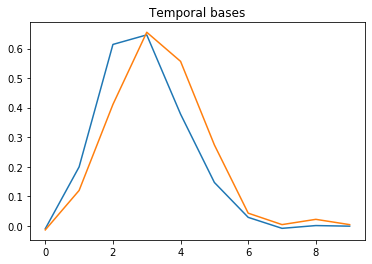

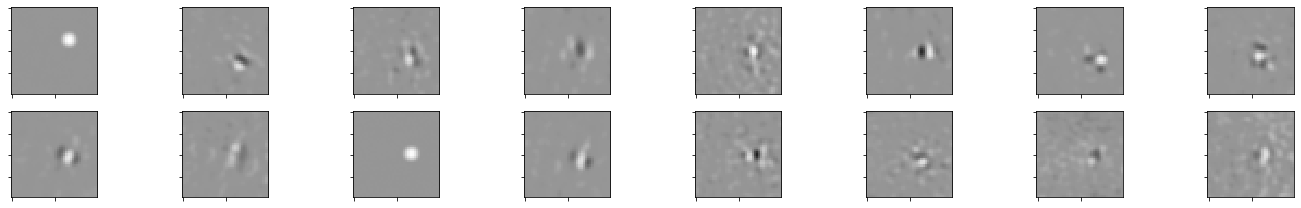

In [13]:
plt.plot(sacnim1.networks[1].layers[0].weights,'g')
plt.plot(sacnim1.networks[2].layers[0].weights,'r')
plt.show()
DU.plot_filters(sacnim1)

In [12]:
# GAIN FROM SAC ONSET, ADDITIVE FIX ONSET
num_tkerns = 2
num_subs = 16
Treg = 0.001
TSreg2 = 0.001
num_Esubs = 14
num_Isubs = 2

In [68]:
mnim1_par = NDNutils.ffnetwork_params( 
    input_dims=[1,NY,NX, num_lags], layer_sizes=[num_tkerns, num_Esubs+num_Isubs, NC], 
    layer_types=['conv', 'normal', 'normal'], conv_filter_widths=[1], ei_layers=[None, num_Isubs],
    normalization=[1,1,0], act_funcs=['lin', 'relu', 'lin'],
    reg_list={'d2t':[Treg], 'd2x':[None, Xreg], 'l1':[None, L1reg/2], 'local':[None,LOCreg]})
sac1_par = NDNutils.ffnetwork_params( 
    input_dims=[1,1,1, num_saclags], xstim_n=[1],
    layer_sizes=[1, NC], layer_types=['normal', 'normal'], normalization=[1,0], act_funcs=['lin', 'lin'],
    reg_list={'d2t':[TSreg2]})
stim_par = NDNutils.ffnetwork_params( 
    xstim_n=None, ffnet_n=[0,1],
    layer_sizes=[NC], layer_types=['mult'], normalization=[0], act_funcs=['lin'])
sac2_par = NDNutils.ffnetwork_params( 
    input_dims=[1,1,1, num_saclags], xstim_n=[2],
    layer_sizes=[1, NC], layer_types=['normal', 'normal'], normalization=[1, 0], act_funcs=['lin', 'lin'],
    reg_list={'d2t':[TSreg2]})
comb_par = NDNutils.ffnetwork_params( 
    xstim_n=None, ffnet_n=[2,3], layer_sizes=[NC], layer_types=['add'], act_funcs=['softplus'])

gmodsac0 = NDN.NDN( [mnim1_par, sac1_par, stim_par, sac2_par, comb_par], ffnet_out=4, noise_dist='poisson' )
gmodsac0.networks[0].layers[0].weights = deepcopy(sacnim1.networks[0].layers[0].weights)
gmodsac0.networks[0].layers[1].weights = deepcopy(sacnim1.networks[0].layers[1].weights)
gmodsac0.networks[0].layers[1].biases = deepcopy(sacnim1.networks[0].layers[1].biases)
gmodsac0.networks[0].layers[2].weights = deepcopy(sacnim1.networks[0].layers[2].weights)

In [24]:
v2f0 = gmodsac0.fit_variables(layers_to_skip=[[0,1,2]], fit_biases=True)
v2f0[1][1]['biases']=False
v2f0[2][0]['biases']=False
v2f0[3][1]['biases']=False
v2f0[4][0]['weights']=False

v2f = gmodsac0.fit_variables(layers_to_skip=[[0]], fit_biases=True)
v2f[0][2]['biases']=False
v2f[1][1]['biases']=False
v2f[2][0]['biases']=False
v2f[3][1]['biases']=False
v2f[4][0]['weights']=False

adam_params = NDN.NDN.optimizer_defaults(opt_params={'use_gpu': False}, learning_alg='adam')

early_stopping = 100

adam_params['batch_size'] = NT // 1000
adam_params['display'] = 30
adam_params['epochs_training'] = early_stopping * 10
adam_params['run_diagnostics'] = False

adam_params['epsilon'] = 1e-8
adam_params['early_stop'] = early_stopping
adam_params['early_stop_mode'] = 11
#adam_params['data_pipe_type'] = 'iterator'
adam_params['data_pipe_type'] = 'data_as_var'
adam_params['learning_rate'] = 1e-3
#adam_params['epochs_summary'] = 5
for d in adam_params:
    print("%20s:\t %s" %(d, adam_params[d]))

lbfgs_params = NDN.NDN.optimizer_defaults(opt_params={'use_gpu': True, 'display': True}, learning_alg='lbfgs')
lbfgs_params['maxiter'] = 1000

             use_gpu:	 False
             display:	 30
      data_pipe_type:	 data_as_var
   poisson_unit_norm:	 None
         epochs_ckpt:	 None
       learning_rate:	 0.001
          batch_size:	 105
     epochs_training:	 1000
     early_stop_mode:	 11
      epochs_summary:	 None
          early_stop:	 100
               beta1:	 0.9
               beta2:	 0.999
             epsilon:	 1e-08
     run_diagnostics:	 False


In [25]:
# or load gmodsac
fname = dirname + "gmodsac0_1231"
gmodsac0 = NDN.NDN.load_model(fname)


_ = gmodsac0.train(
    input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], output_data=Robs[valdata,:], 
    train_indxs=Ui, test_indxs=Xi,
    learning_alg='adam', opt_params=adam_params)

Epoch 0000:  avg train cost =     3.3845,  avg test cost =     3.3459,  reg penalty =     0.0727
Epoch 0029:  avg train cost =     3.3332,  avg test cost =     3.3145,  reg penalty =     0.0652
Epoch 0059:  avg train cost =     3.3281,  avg test cost =     3.3141,  reg penalty =     0.0614
Epoch 0089:  avg train cost =     3.3284,  avg test cost =     3.3239,  reg penalty =     0.0596
Epoch 0119:  avg train cost =     3.3232,  avg test cost =     3.3183,  reg penalty =     0.0581

*** early stop criteria met...stopping train now...
     ---> number of epochs used: 120,  end cost: 195.971311
     ---> best epoch: 56,  best cost: 195.657081



In [16]:
# dont fit stim terms yet
# _ = gmodsac0.train(
#     input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], output_data=Robs[valdata,:], 
#     train_indxs=Ui, test_indxs=Xi, fit_variables=v2f0, 
#     learning_alg='adam', opt_params=adam_params)

# now fit stim terms too 
_ = gmodsac0.train(
    input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], output_data=Robs[valdata,:], 
    train_indxs=Ui, test_indxs=Xi, fit_variables=v2f, 
    learning_alg='adam', opt_params=adam_params)

LL1u = gmodsac0.eval_models(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Ui, nulladjusted=False)
LL1x = gmodsac0.eval_models(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=False)
LL1n = gmodsac0.eval_models(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], 
                           output_data=Robs[valdata,:], data_indxs=Xi, nulladjusted=True)

print(np.mean(LL1u), np.mean(LL1x), np.mean(LL1n))

NameError: name 'v2f' is not defined

In [ ]:
gmodsac0.save_model(dirname + "gmodsac0_1231")

gmodsac0.matlab_export(dirname + "gmodsac0export_1231")

# predrate = gmodsac0.generate_prediction(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]])
predrate = gmodsac0.generate_prediction(input_data=[tmp, Xsac1, Xsac2])

sio.savemat(dirname + "gmodsac0_output.mat", dict([ ('LLs0', LL1x), ('predrate', predrate), ('valdata', valdata), ('Robs', Robs), ('sac_on', sac_on), ('sac_off', sac_off), ('frameTimes', frameTimesAll)]))

Model pickled to C:\Users\Jake\Dropbox\Projects\FreeViewing\Data\gmodsac0_1231


In [ ]:
gmodsac0.set_regularization('d2t', 0.02, ffnet_target = 1, layer_target=0)
# dont fit stim terms yet
_ = gmodsac0.train(
    input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], output_data=Robs[valdata,:], 
    train_indxs=Ui, test_indxs=Xi, fit_variables=v2f0, 
    learning_alg='adam', opt_params=adam_params)

Epoch 0000:  avg train cost =     3.3129,  avg test cost =     3.3591,  reg penalty =     0.0747
Epoch 0029:  avg train cost =     3.3127,  avg test cost =     3.3610,  reg penalty =     0.0744
Epoch 0059:  avg train cost =     3.3127,  avg test cost =     3.3607,  reg penalty =     0.0744


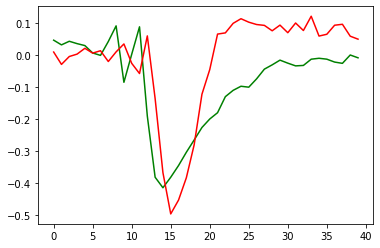

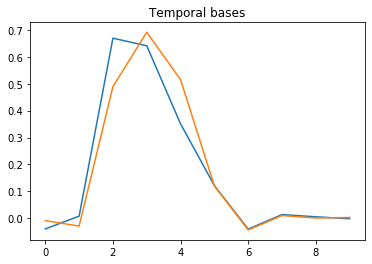

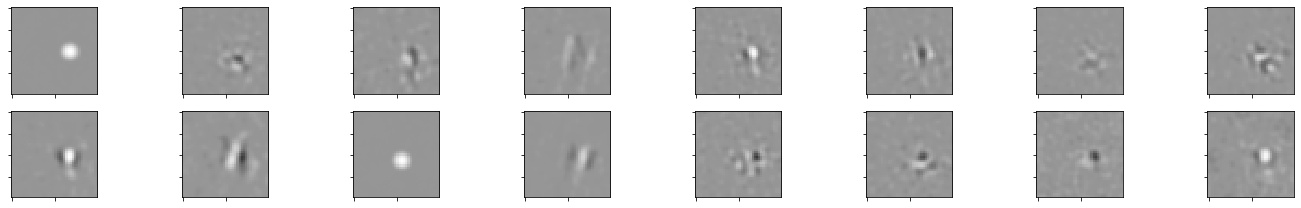

In [26]:
plt.plot(gmodsac0.networks[3].layers[0].weights,'g')
plt.plot(gmodsac0.networks[1].layers[0].weights,'r')
plt.show()
DU.plot_filters(gmodsac0)

In [74]:
gmodsac0.networks[2]


Warning, GPU setup must happen before importing TensorFlow


In [73]:
v2f0 = gmodsac0.fit_variables(layers_to_skip=[[1,2]], fit_biases=True)
gmodsac1 = gmodsac0.copy_model()
gmodsac1.set_regularization('d2t', 0.0002, ffnet_target = 0, layer_target=0)
gmodsac1.set_regularization('l1', L1reg, ffnet_target = 0, layer_target=1)
_ = gmodsac1.train(
    input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]], output_data=Robs[valdata,:], 
    train_indxs=Ui, test_indxs=Xi, fit_variables=v2f0, 
    learning_alg='adam', opt_params=adam_params)

Epoch 0000:  avg train cost =     3.3190,  avg test cost =     3.3255,  reg penalty =     0.1058
Epoch 0029:  avg train cost =     3.3162,  avg test cost =     3.3203,  reg penalty =     0.1058


KeyboardInterrupt: 

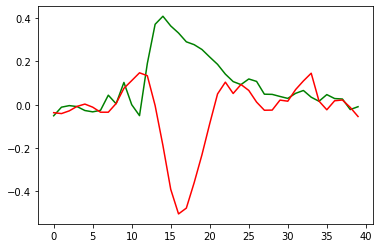

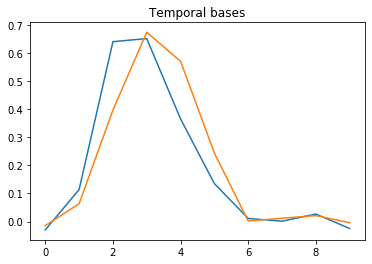

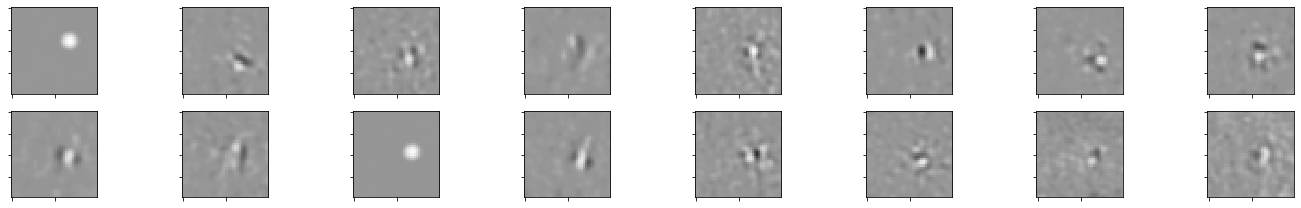

In [57]:
plt.plot(gmodsac1.networks[3].layers[0].weights,'g')
plt.plot(gmodsac1.networks[1].layers[0].weights,'r')
plt.show()
DU.plot_filters(gmodsac1)

In [59]:
gmodsac1.save_model(dirname + "gmodsac0_1231")

gmodsac1.matlab_export(dirname + "gmodsac0export_1231")

# predrate = gmodsac0.generate_prediction(input_data=[Xstim, Xsac1[valdata,:], Xsac2[valdata,:]])
predrate = gmodsac1.generate_prediction(input_data=[tmp, Xsac1, Xsac2])

sio.savemat(dirname + "gmodsac0_output.mat", dict([ ('LLs0', LL1x), ('predrate', predrate), ('valdata', valdata), ('Robs', Robs), ('sac_on', sac_on), ('sac_off', sac_off), ('frameTimes', frameTimesAll)]))

Model pickled to C:\Users\Jake\Dropbox\Projects\FreeViewing\Data\gmodsac0_1231
